# Working with Raster Datasets

Teaching: 45 min 
Exercises: 0 min Questions
How can I extract pixel values from rasters and perform computations?

How might I write pixel values out to a new raster file?

Objectives
Understand the basic components of a raster dataset and how to access them from a python program.

Perform numerical operations on pixel values.

Read from and write to raster datasets.

# 1.背景
[GDAL](https://en.wikipedia.org/wiki/GDAL)是一个功能强大且成熟的库，用于读取，编写和扭曲栅格数据集，用C ++编写，绑定到其他语言。python包索引上有各种地理空间库，几乎所有这些库都依赖于GDAL。由Mapbox开发和支持的一个这样的python库rasterio构建在GDAL的许多功能之上，但提供了更加pythonic的界面，并支持GDAL支持的许多功能和格式。GDAL和rasterio都在不断更新和改进：在撰写本教程（2018年7月）时，GDAL版本为2.3.1，rasterio版本为1.0.2。

**什么时候应该直接使用GDAL？**

如果您对终端感到满意，GDAL的命令行实用程序对于脚本编写非常有用。
请注意，GDAL也有自动生成的Python绑定，但我们建议使用rasterio！

**什么时候应该使用rasterio而不是GDAL？**

也许总是？！Rasterio还有一套命令行工具
如果您在Python环境中工作（ipython，脚本，jupyter实验室）

**什么时候这些不是最好的工具？**

这两个库对于输入/输出操作都很关键，但是您将利用其他库进行计算（例如numpy）
也就是说，GDAL确实有一些标准的处理脚本（例如全色锐化），而rasterio 为工作流程提供了一个插件界面
对于抛光地图创建和交互式可视化，像QGIS这样的桌面GIS软件可能是更好，更全面的选择。

# 2.加载和查看Landsat 8图像
Landsat计划是历时最长的民用卫星图像计划，第一颗卫星于1972年由美国地质调查局发射。Landsat 8是该计划的最新卫星，于2013年发射.Landsat观测被处理成“场景”，每个场景约183公里x 170公里，空间分辨率为30米，时间分辨率为16天。Landat计划的持续时间使其成为陆地表面变化分析的中等尺度图像的有吸引力的来源。Landsat是多波段图像，您可以在这里阅读更多相关信息。

我们将Landsat 8用于此演示的一个原因是整个Landsat 8存档由各种商业云提供商托管，可免费公开访问（AWS和Google Cloud）！

我们首先导入本教程中所需的所有python库：

云上的卫星档案
单个Landsat8场景大小约为1 Gb，因为它包含每个图像带的大量数据。图像通常被分组为单个.tar.gz文件，这需要科学家下载整个1 Gb，即使您只对图像的单个波段或子集感兴趣。为了规避下载，已经为云存储提出了一种称为云优化地理搜索（COG）的新格式，以便轻松访问单个频段甚至单个图像的子集。

从严格意义上讲，AWS和Google Cloud上的Landsat图像不是COG（您可以使用此类在线工具验证格式 - http://cog-validate.radiant.earth/html）。尽管如此，文件存储为平铺Geotiff，因此许多COG功能仍然有效。

AWS与Google Cloud
您可以使用NASA的Earthdata Search网站来发现数据。Landsat图像按“路径”和“行”组织。我们从第42行第34行中选择了一个没有多个云的场景（LC08_L1TP_042034_20170616_20170629_01_T1）。请注意，'T1'代表'第1层'（用于分析用途），'RT'代表'实时'，质量控制不是那么严格。在此处阅读有关各种Landsat格式和集合的更多信息。乍一看，您似乎可以在AWS或Google Cloud上找到此数据，例如，查看我们选择的日期的第4频段图像：

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

或者，Google云端存储上提供了相同的文件：

https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF

In [1]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#https://geohackweek.github.io/raster/04-workingwithrasters/

In [2]:
print('Landsat on Google:')
filepath = 'D:/data/lights/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [16]:
print('Landsat on AWS:')
filepath = 'D:/data/lights/AWS-LC08_L1TP_042034_20170616_20170629_01_T1_B4.tif'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS({'init': 'epsg:32611'}), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## 刚刚发生了什么？
如果你熟悉python中的编程，你可能以前见过上下文管理器。这个上下文管理器rasterio.open（）的功能类似于打开文件的python标准库函数。打开文件后，将执行with ... as语句中的代码块，并在上下文管理器退出时关闭该文件。这意味着我们不必手动关闭栅格文件，因为上下文管理器会为我们处理。

rasterio不是本地文件路径，而是知道如何读取URL，因此我们只是将链接传递给AWS上的文件

src.profile是文件的元数据集合。我们看到它是Geotiff（Gtiff），图像值是无符号整数格式，未分配节点值，图像的尺寸为7711x7531，是单个波段，是UTM坐标，有简单的仿射变换，是分成较小的512x512阵列，在存储它的AWS硬盘上平铺和压缩。

请注意，我们实际上并没有下载图像！我们只是阅读元数据。

您是否了解了AWS上的数据与Google上的数据之间的细微差别？图像块大小或“平铺”是不同的，压缩方案也是如此。事实证明，AWS存储了预先制作的图像概述，但Google却没有。重要的是要意识到并非所有档案都是一样的！实际上，Google Cloud存储档案是完整的USGS档案的完整镜像，而在撰写本文时，AWS仅在2017年之后收集了1个场景。通常，如果您在本地访问数据，性能将是最佳的（如果您是在AWS上运行此笔记本，使用AWS上的landsat公共数据！由于概述的便利性，我们将在本教程的其余部分使用AWS存档：

## Plot a low-resolution overview

In [18]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   print(oviews)
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

[]
Decimation factor= []


TypeError: unsupported operand type(s) for //: 'int' and 'list'

Earlier we saw in the metadata that a no-data value wasn’t set, but pixels outside the imaged area are clearly set to “0”. Images commonly look like this because of satellite orbits and the fact that the Earth is rotating as imagery is acquired! The colormap is often improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (so be aware the array with NaNs will take 2x the storage space). The serrated edge is due to the coarse sampling of the full resolution image that we are doing here.

In [19]:
with rasterio.open(filepath) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

IndexError: list index out of range

Another nice feature of COGs is that you can request a subset of the image and only that subset will be downloaded to your computer:

Text(0, 0.5, 'Row #')

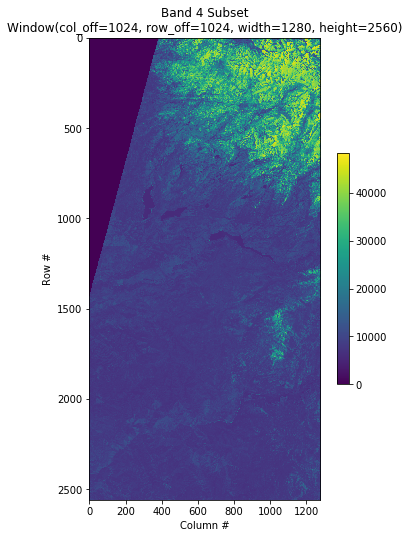

In [20]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(filepath) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

# 3. Example computation: NDVI
The Normalized Difference Vegetation Index is a simple indicator that can be used to assess whether the target includes healthy vegetation. This calculation uses two bands of a multispectral image dataset, the Red and Near-Infrared (NIR) bands:

For this tutorial, we’ll use the NIR and Red bands from a Landsat-8 scene above part of the central valley and the Sierra Nevada in California. We’ll be using Level 1TP datasets, orthorectified, map-projected images containing radiometrically calibrated data.

**Bands**

Red: Band 4

Near-Infrared: Band 5

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files. Some other rasters may store multiple bands in the same file.

Decimation factor= 9


Text(0, 0.5, 'Row #')

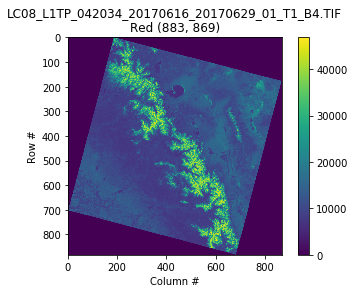

In [11]:
# Use the same example image:
date = '2017-06-16'
url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

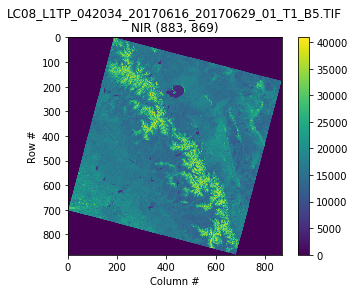

In [21]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

C:\Users\xigrug\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, 'Row #')

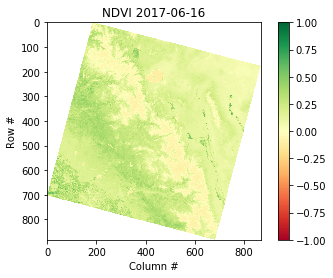

In [22]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

# 4. Save the NDVI raster to local disk
So far, we have read in a cloud-optimized geotiff from the Cloud into our computer memory (RAM), and done a simple computation. What if we want to save this result locally for future use?

Since we have used a subsampled overview, we have to modify the orginal metadata before saving! In particular, the Affine matrix describing the coordinates is different (new resolution and extents, and we’ve changed the datatype). We’ll stick with Geotiff, but note that it is no longer cloud-optimized.

In [23]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

Be sure to check that the saved file looks the same:

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 869, 'height': 883, 'count': 1, 'crs': None, 'transform': Affine(270.0, 0.0, 204285.0,
       0.0, -270.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

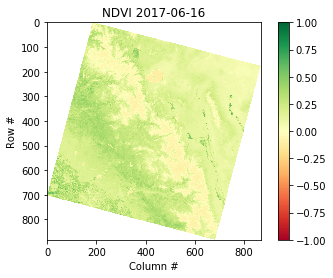

In [24]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

Note that rasterio also has a ‘convenience method’ for plotting with georeferenced coordinates

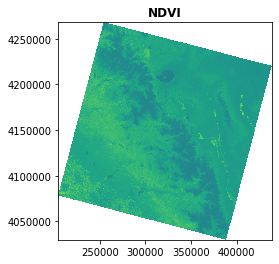

In [25]:
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI')

## Spatial indexing and extracting values
Raster images really have two sets of coordinates. First, ‘image coordinates’ correspond to the row and column for a specific pixel. Second, the ‘spatial coordinates’ correspond to the location of each pixel on the surface of the Earth. Rasterio makes it convenient to use both coordinate systems.

Lets say you want the value of NDVI at a specific point in this scene. For example Fresno, CA (-119.770163586, 36.741997032). But the image is in UTM coordinates, so you have to first convert these points to UTM (Many websites will do this for you https://www.geoplaner.com), or you can use the pyproj library. Be warned that this only works if you read the dataset at it’s full resolution (if you do decimated or windowed reads of the file, you need to adjust the affine transform).

In [26]:
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (-119.770163586, 36.741997032)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 200, 450
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
    print(f'''
Interesting Feature
-------
row,col=          ({row},{col})
easting,northing= ({east:g},{north:g})
lon,lat=          ({lon:.2f},{lat:.2f})
ndvi=              {value:.2f}
''')

RuntimeError: no projection control parameters specified

# 5. Calculate change in NDVI over time
Let’s take a look at the difference in NDVI between a scene in June 2013 and June 2017. If you went to the AWS Landsat Archive page, you probably noticed that it isn’t obvious how to search and discover images (most of the time you probably won’t know the row, path, or full URL of images over your area of interest!) There are many options for searching, graphical web applications like NASA’s Earthdata Search, or convenient Python tools like DevSeed’s sat-search, among many others! We won’t go into these tools here, but we encourage you to experiment with your own image scenes. Here is a file from June 2018 that was easy to find with Landsat for AWS using the Path and Row from the earlier URL:

https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1

With the band 4 imagery URL:

http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B4.TIF

In [27]:
# Use the same example image:
date2 = '2018-06-19'
url2 = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/'
redband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(4)
nirband2 = 'LC08_L1TP_042034_20180619_20180703_01_T1_B{}.TIF'.format(5)

filepath = url2+redband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

filepath = url2+nirband2
with rasterio.open(filepath) as src:
    print('Opening:', filepath)
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    nir2 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

ndvi2 = calc_ndvi(nir2, red2)

Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B4.TIF
Decimation factor= 9
Opening: http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20180619_20180703_01_T1/LC08_L1TP_042034_20180619_20180703_01_T1_B5.TIF
Decimation factor= 9


C:\Users\xigrug\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


And plot the results with matplotlib:

Text(0.5, 1.0, 'Diff (2018-06-19 - 2017-06-16)')

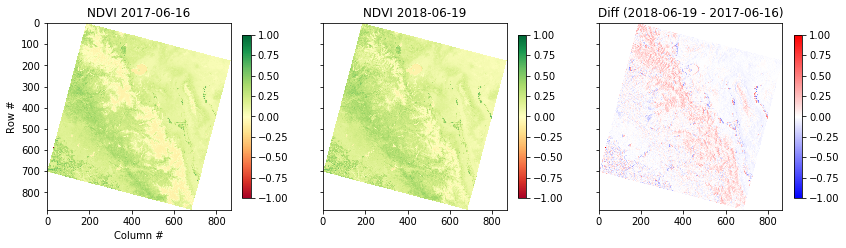

In [28]:
fig, axes = plt.subplots(1,3, figsize=(14,6), sharex=True, sharey=True)

plt.sca(axes[0])
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.sca(axes[1])
plt.imshow(ndvi2, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('NDVI {}'.format(date2))

plt.sca(axes[2])
plt.imshow(ndvi2 - ndvi, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(shrink=0.5)
plt.title('Diff ({} - {})'.format(date2, date))

### What just happened?
We just loaded 4 decimated Landsat 8 band images into memory and computed the difference in NDVI between two dates. That was relatively easy because these two rasters happen to use the same coordinate system and grid. This is know as ‘Analysis Ready Data’. In the geosciences, we commonly have data in WGS84 Lat, Lon. Or what if you want to compare to NDVI estimated from Sentinel-2 satellite acquisitions, which are on a different grid?

# 6. Advanced uses of rasterio
Rasterio can also be used for masking, reprojecting, and regridding distinct datasets. Here is one simple example to reproject our local NDVI onto a WGS84 Lat/Lon Grid. The example creates a ‘VRT’ file, which is merely a ASCII text file describing the transformation and other image metadata. The array values do no need to be duplicated, the VRT file just contains a reference to the local file (LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif). This is extremely useful to avoid duplicating lots of data and filling up your computer!

In [29]:
import rasterio.warp
import rasterio.shutil

localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
vrtname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.vrt'

with rasterio.open(localname) as src:
    with rasterio.vrt.WarpedVRT(src, crs='epsg:4326', resampling=rasterio.enums.Resampling.bilinear) as vrt:
        rasterio.shutil.copy(vrt, vrtname, driver='VRT')

# Open the local warped file and plot
# NOTE our coordinates have changed to lat, lon. we should probably crop the edge artifacts do to reprojection too!
with rasterio.open(vrtname) as src:
    rasterio.plot.show(src, title='NDVI', cmap='RdYlGn', vmin=-1, vmax=1)


CRSError: CRS is invalid: None

The issue with VRTs is now you have two files and let’s say you want to share this image with a colleague. Also if you move things around on your computer, the paths might get mixed up, so in some cases it’s nice to save a complete reprojected file. The second code block does this, saving our NDVI as a Geotiff in WGS84:

In [ ]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'
tifname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW_WGS84.tif'

dst_crs = 'EPSG:4326'

with rasterio.open(localname) as src:
    profile = src.profile.copy()

    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(tifname, 'w', **profile) as dst:
        rasterio.warp.reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=rasterio.warp.Resampling.bilinear)

Additional resources
This just scratches the surface of what you can do with rasterio. Check out the excellent official documentation as you continue exploring:

https://rasterio.readthedocs.io/en/latest

Key Points
Rasterio is built around the GDAL library (recall section 3), to facilitate raster operations in Python.

Pixel values of rasters can be extracted to a numpy array.

Computation is done in local memory on numpy arrays, then saved to the raster format of choice.